## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
import pickle as pickle
from class_telescope import Telescope
from image_time_series import simulate_time_series_images
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


In [2]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
num_samples = 1000
# ---------------------------------

lsst = Telescope(telescope, bandpasses, num_samples)


Setting up OpSim Summary generator...
 reading from database sqlite:///../data/OpSim_databases/baseline_v3.0_10yrs.db
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
dithered column names exists 
Changing units for fbsv2 from degrees


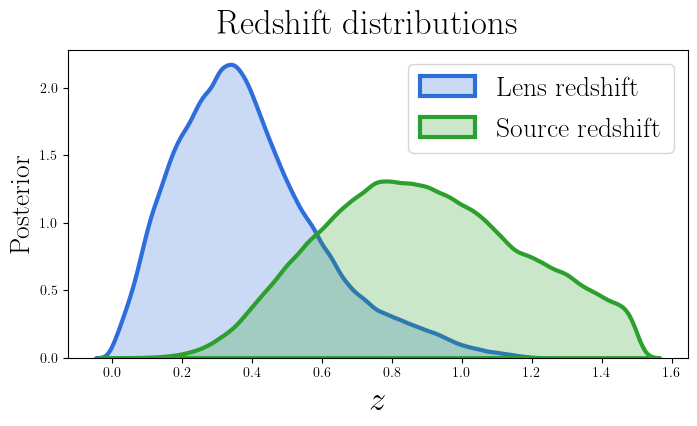

In [3]:
lsst.plot_redshifts()

### Seeing distributions
Sample the PSF from the predicted seeing distribution for the <b> baseline v2.0 </b> observing strategy for 10 years.

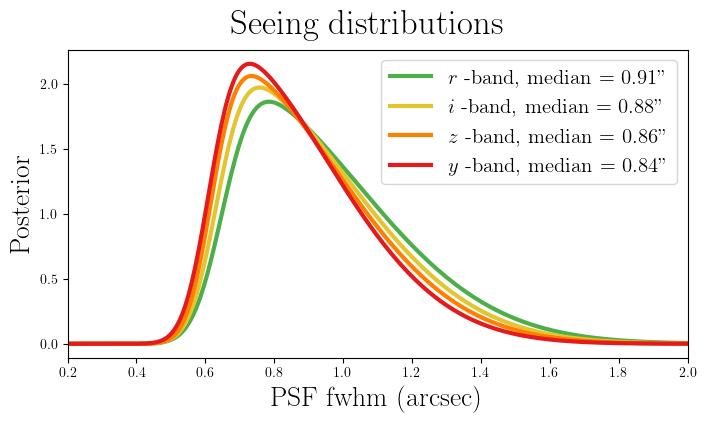

In [4]:
lsst.plot_seeing_distributions()


### Cadence

Sample the cadence from the predicted distribution for the <b> baseline v2.0 </b> observing strategy for the LSST Wide, Fast, Deep survey from Catarina Alves' simulations.


In [5]:
# lsst.plot_cadence()


### Generation of training and test sets


  0%|                                                                | 0/1 [00:00<?, ?it/s]

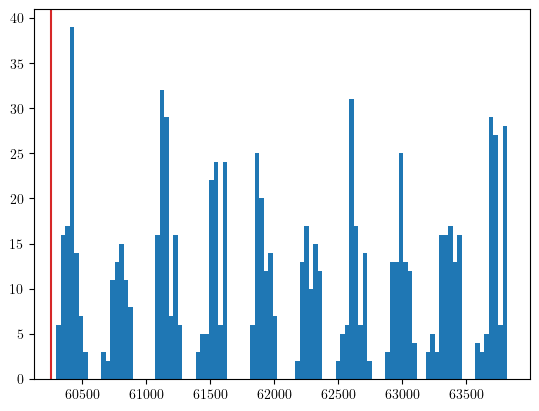

Theoretically visible with image multiplicity method?            True
Theoretically visible with magnification method?                 False
Observations allow for detection with image multiplicity method? True
Observations allow for detection with magnification method?      False
 
Lens redshift:  0.35
Supernova redshift:  0.75
Einstein radius:  0.43
Time delays:  [ 0.   19.69] days
Macro magnification:  [2.13 0.58]
Microlensing contribution at peak (magnitudes):  0.0
Hubble constant:  67.8
Time-delay distance:  2929.14
Peak brightness images for r,i,z,y bands:
[[23.63 24.25]
 [22.84 23.51]
 [23.45 23.89]
 [21.99   inf]]
 


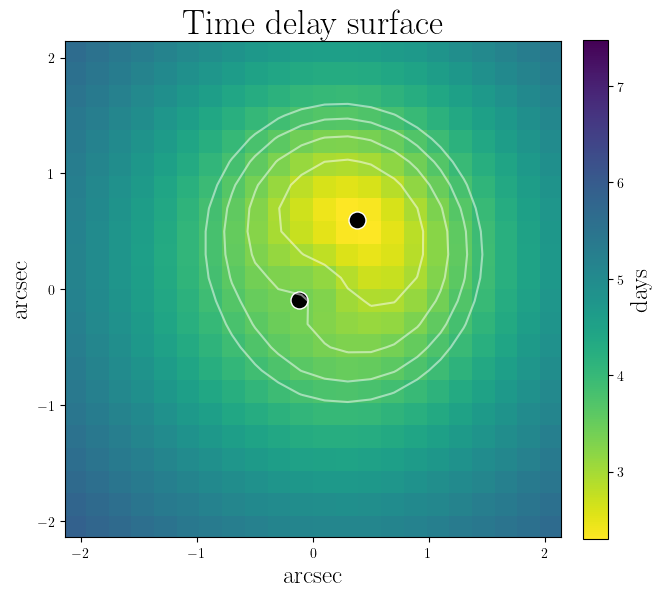

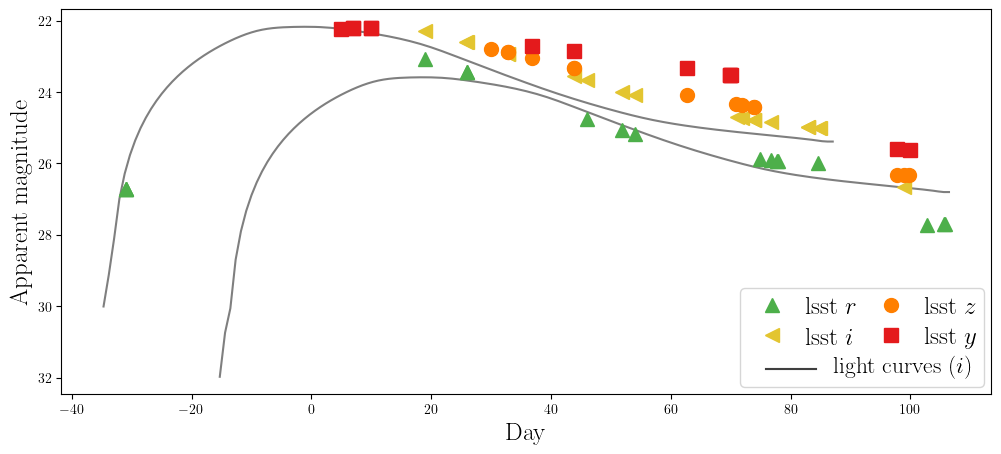

33.59701758449313 21.592871134215276
32.975309304497344 21.170939497805467
32.97860443597355 21.3965729897695
33.035319486327744 21.377133223097818


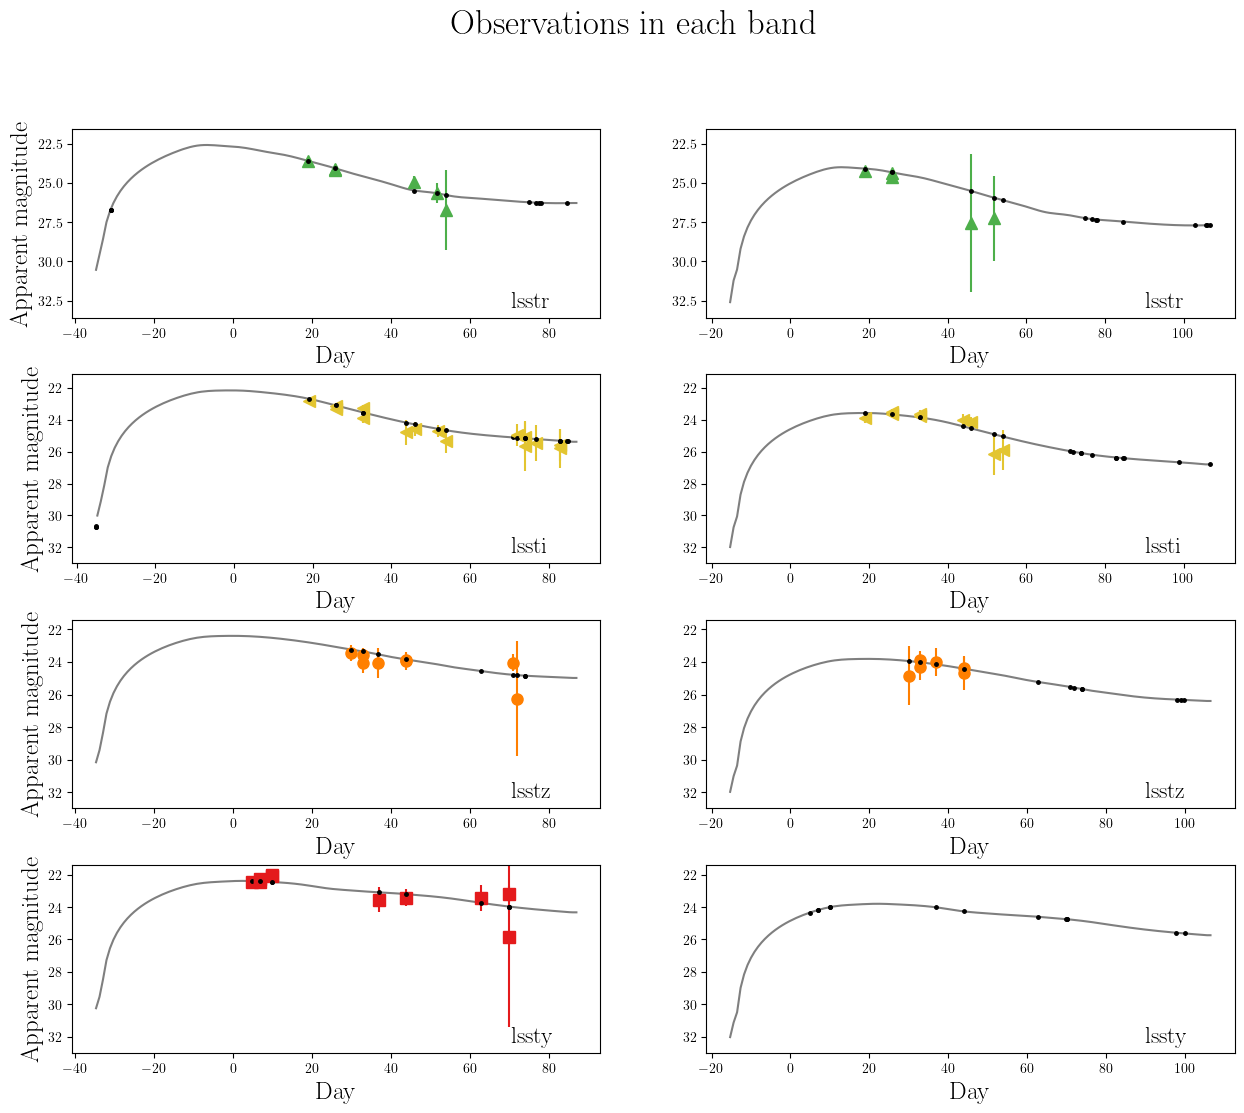

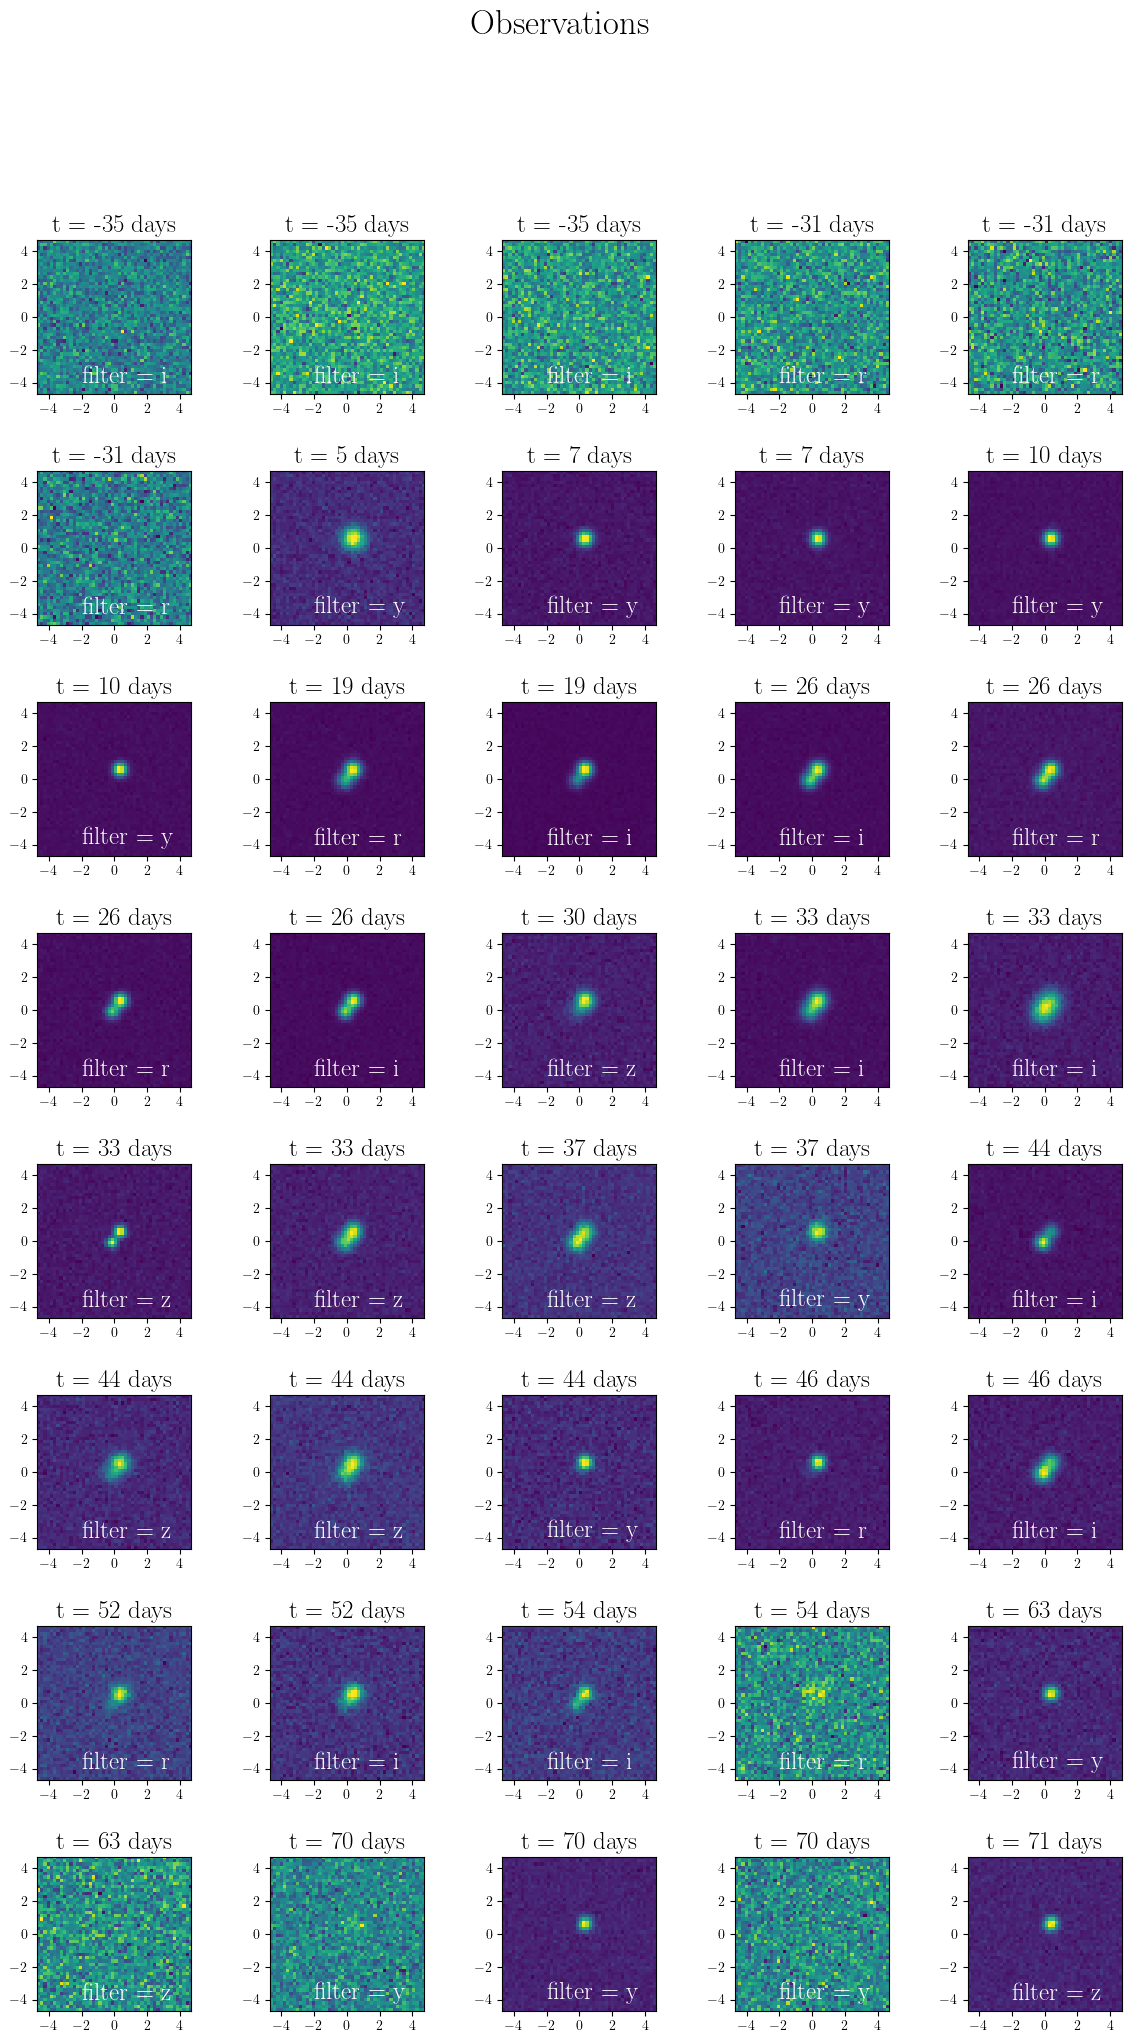

100%|████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

Done!
Simulating images took  6.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  1
Number of attempts:  6
 


100%|████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]

                                         time_series  z_source    z_lens  \
0  [[[-0.26010133172366634, -0.3326576108860589, ...  0.752064  0.348859   

     H0   theta_E                                           obs_peak  \
0  67.8  0.427817  [[23.634463578182945, 24.245381175898988], [22...   

                                           obs_times  \
0  [-35.041274327159044, -35.03817613967112, -35....   

                                           obs_bands  \
0  [i, i, i, r, r, r, y, y, y, y, y, r, i, i, r, ...   

                                           model_mag  \
0  [[30.7061879031656, inf], [30.69699919309411, ...   

                                             obs_mag  ...     obs_start  \
0  [[inf, inf], [inf, inf], [inf, inf], [inf, inf...  ...  60294.350313   

      obs_end mult_method_peak mult_method mag_method_peak mag_method  \
0  60436.2303             True        True           False      False   

                                      coords  \
0  [204.415525479

In [18]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 2                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 200         # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = True               # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Baseline_v_3_0/" # Path to folder in which to save the results


df, timings = simulate_time_series_images(num_samples, batch_size, batch, num_images, add_microlensing, 
                                 obs_lower_limit, obs_upper_limit, fixed_H0, lsst, Show, Save, path)


In [25]:
times = df['obs_times'][0]
modelmag = df['model_mag'][0]
obsmag = df['obs_mag'][0]
magerr = df['obs_mag_error'][0]
limmag = df['obs_lim_mag'][0]
snr = df['obs_snr'][0]

inf1 = times[obsmag[:,0] == np.inf]
inf2 = times[obsmag[:,1] == np.inf]

#print(times)
#print(" ")
#print(modelmag)

Text(0, 0.5, 'Apparent magnitude')

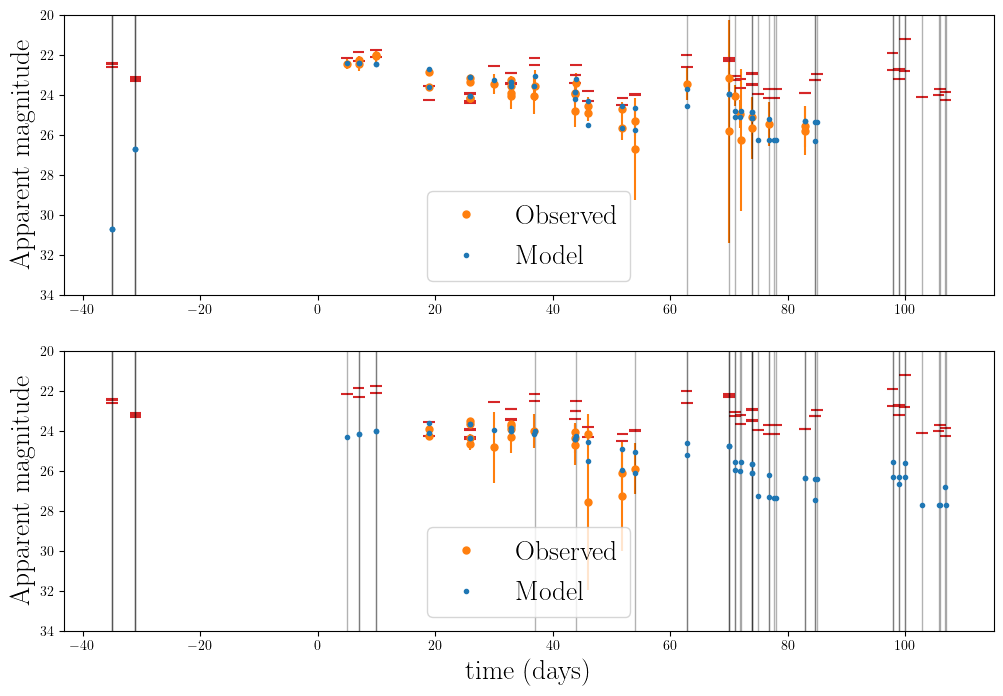

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for i in inf1:
    ax[0].axvline(i, lw=1, color='black', alpha=0.3)
ax[0].plot(times, obsmag[:,0], '.', color='C1', ms=10, label='Observed')
ax[0].vlines(times, obsmag[:,0] - magerr[:,0], obsmag[:,0] + magerr[:,0], color='C1')
ax[0].plot(times, modelmag[:,0], '.', color='C0', label='Model')
for j in range(len(times)):
    ax[0].hlines(limmag[j], times[j] - 1, times[j] + 1, color='C3')
ax[0].set_ylim(34, 20)
ax[0].legend(loc='lower center', fontsize=20)
ax[0].set_ylabel("Apparent magnitude", fontsize=20)

for i in inf2:
    ax[1].axvline(i, lw=1, color='black', alpha=0.3)
ax[1].plot(times, obsmag[:,1], '.', ms=10, color='C1', label='Observed')
ax[1].vlines(times, obsmag[:,1] - magerr[:,1], obsmag[:,1] + magerr[:,1], color='C1')
ax[1].plot(times, modelmag[:,1], '.', color='C0', label='Model')
for j in range(len(times)):
    ax[1].hlines(limmag[j], times[j] - 1, times[j] + 1, color='C3')
ax[1].legend(loc='lower center', fontsize=20)
ax[1].set_ylim(34, 20)
ax[1].set_xlabel("time (days)", fontsize=20)
ax[1].set_ylabel("Apparent magnitude", fontsize=20)

# plt.savefig("../results/figures/data_gaps2.png", dpi=250)

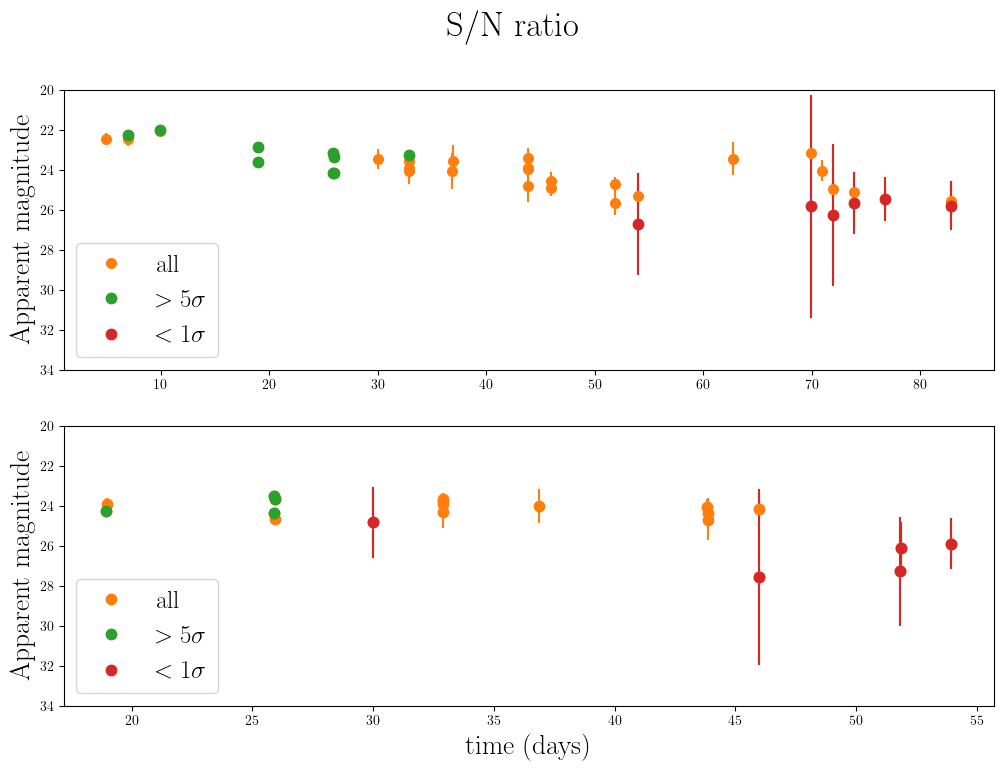

In [54]:
ind1_5s = snr[:,0] > 5
ind2_5s = snr[:,1] > 5
ind1_low = snr[:,0] < 1
ind2_low = snr[:,1] < 1

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("S/N ratio", fontsize=25)

ax[0].plot(times, obsmag[:,0], '.', color='C1', ms=14, label='all')
ax[0].vlines(times, obsmag[:,0] - magerr[:,0], obsmag[:,0] + magerr[:,0], color='C1')
ax[0].vlines(times[ind1_5s], obsmag[:,0][ind1_5s] - magerr[:,0][ind1_5s], obsmag[:,0][ind1_5s] + magerr[:,0][ind1_5s], color='C2')
ax[0].vlines(times[ind1_low], obsmag[:,0][ind1_low] - magerr[:,0][ind1_low], obsmag[:,0][ind1_low] + magerr[:,0][ind1_low], color='C3')
ax[0].plot(times[ind1_5s], obsmag[:,0][ind1_5s], '.', color='C2', ms=15, label=r'$>$ 5$\sigma$')
ax[0].plot(times[ind1_low], obsmag[:,0][ind1_low], '.', color='C3', ms=15, label=r'$<$ 1$\sigma$')
#ax[0].plot(times, modelmag[:,0], '.', color='C0', label='Model')
ax[0].set_ylim(34, 20)
ax[0].legend(loc='lower left', fontsize=18)
ax[0].set_ylabel("Apparent magnitude", fontsize=20)

ax[1].plot(times, obsmag[:,1], '.', ms=15, color='C1', label='all')
ax[1].vlines(times, obsmag[:,1] - magerr[:,1], obsmag[:,1] + magerr[:,1], color='C1')
ax[1].vlines(times[ind2_5s], obsmag[:,1][ind2_5s] - magerr[:,1][ind2_5s], obsmag[:,1][ind2_5s] + magerr[:,1][ind2_5s], color='C2')
ax[1].vlines(times[ind2_low], obsmag[:,1][ind2_low] - magerr[:,1][ind2_low], obsmag[:,1][ind2_low] + magerr[:,1][ind2_low], color='C3')
ax[1].plot(times[ind2_5s], obsmag[:,1][ind2_5s], '.', color='C2', ms=15, label=r'$>$ 5$\sigma$')
ax[1].plot(times[ind2_low], obsmag[:,1][ind2_low], '.', color='C3', ms=15, label=r'$<$ 1$\sigma$')
#ax[1].plot(times, modelmag[:,1], '.', color='C0', label='Model')
ax[1].legend(loc='lower left', fontsize=18)
ax[1].set_ylim(34, 20)
ax[1].set_xlabel("time (days)", fontsize=20)
ax[1].set_ylabel("Apparent magnitude", fontsize=20)

#plt.savefig("../results/figures/snr.png", dpi=250)

In [60]:
print(snr[11])
print(obsmag[11])
print(limmag[11])
print(df['obs_bands'][0])

[8.84800617 5.04055523]
[23.63446358 24.24538118]
24.254152109408224
['i' 'i' 'i' 'r' 'r' 'r' 'y' 'y' 'y' 'y' 'y' 'r' 'i' 'i' 'r' 'r' 'i' 'z'
 'i' 'i' 'z' 'z' 'z' 'y' 'i' 'z' 'z' 'y' 'r' 'i' 'r' 'i' 'i' 'r' 'y' 'z'
 'y' 'y' 'y' 'z' 'i' 'i' 'z' 'i' 'i' 'z' 'z' 'r' 'i' 'r' 'r' 'r' 'i' 'i'
 'r' 'i' 'i' 'y' 'z' 'i' 'z' 'z' 'y' 'r' 'r' 'r' 'i' 'r']


In [10]:
print(df['obs_mag_unresolved'][0])

[        nan         nan 22.31243999 22.27471336 22.22680079 22.59171196]


[50.         50.         50.         50.         50.         50.
  0.2842117   0.36955257  0.21267893  0.19543743  0.29009537  0.07817485
  0.0794977   0.06338851  0.09276005  0.1144052   0.07270038  0.38966638
  0.10879863  0.15084148  0.35095025  0.22644927  0.43864333  0.75935008
  0.2635546   0.32798139  0.30607288  0.50379493  0.36011139  0.18015345
  0.499842    0.27980249  0.46929244  2.55822035  0.82687755 50.
  5.55238144  0.51874311 50.          0.52572902 50.          0.7130147
  3.54575653  0.96636487  1.54807297 50.         50.         50.
  1.10702463 50.         50.         50.          1.00946439  1.2165927
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.         50.         50.
 50.         50.        ]


(28.0, 20.0)

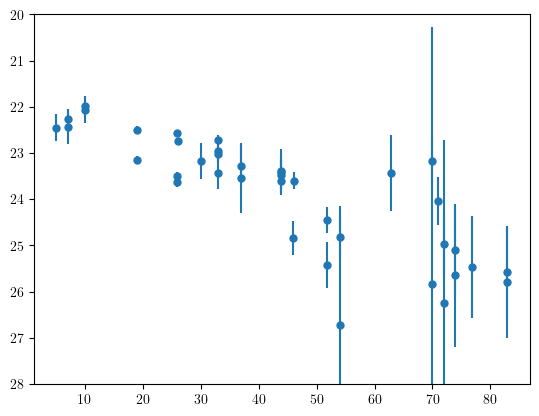

In [21]:
print(df['mag_unresolved_error'][0])

day = df['obs_times'][0]
mags = df['obs_mag_unresolved'][0]
error = df['mag_unresolved_error'][0]

plt.plot(day, mags, '.' , ms=10)
plt.vlines(day, mags - error, mags + error)
plt.ylim(28, 20)

[[22.55366836 23.1378556 ]
 [        inf         inf]
 [        nan         nan]
 [        nan         nan]]
6 6
[-32.32167846 -32.30771326   5.68528904   5.68839913   5.69150924
   5.69461938]
[[       nan        nan]
 [       nan        nan]
 [0.21755298 0.34076205]
 [0.16369216 0.55877013]
 [0.22881653 0.30073632]
 [0.24812751 0.65147276]]
r [inf inf]
i [inf inf]
r [22.84851023 23.33572569]
r [22.55366836 23.88668162]
r [22.84110935 23.1378556 ]
r [22.94209525 23.99014861]


(28.0, 20.0)

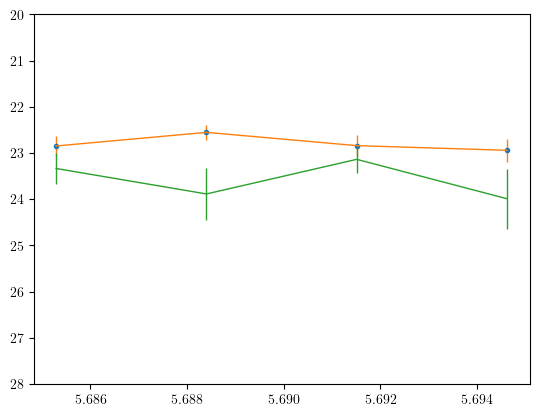

In [12]:
print(df['obs_peak'][0])

print(len(df['obs_times'][0]), len(df['obs_mag'][0]))
print(np.array(df['obs_times'][0]))
indices = np.array(df['obs_bands'][0]) == 'r'

print(df['obs_mag_error'][0])


for i in range(len(df['obs_times'][0])):
    print(df['obs_bands'][0][i], df['obs_mag'][0][i])

plt.figure()
plt.plot(np.array(df['obs_times'][0])[indices], np.array(df['obs_mag'][0])[:,0][indices], '.')
plt.errorbar(np.array(df['obs_times'][0])[indices], np.array(df['obs_mag'][0])[:,0][indices], 
             yerr=np.array(df['obs_mag_error'][0])[:,0][indices], lw=1)
plt.errorbar(np.array(df['obs_times'][0])[indices], np.array(df['obs_mag'][0])[:,1][indices], 
             yerr=np.array(df['obs_mag_error'][0])[:,1][indices], lw=1)

plt.ylim(28, 20)

### Calculate limiting magnitude including weather effects

In [13]:
import sncosmo

index = 8
zeropoint = df['zeropoint'][index]
skysig = np.array(df['skysig'][index])
mag_im = df['brightness_im'][index]
mag_im = mag_im[:len(zeropoint)]
bands = np.array(df['obs_bands'][index])

ab = sncosmo.get_magsystem('ab')
zpfluxes = np.array([ab.zpbandflux('lsst' + b) for b in bands])

print(bands)


KeyError: 'zeropoint'

In [ ]:
# Calculate limiting magnitude from sky noise and zeropoint
m_lim = zeropoint - 2.5*np.log10(5 * np.array(skysig))
print("Limiting magnitudes: ")
print(m_lim)

In [ ]:
# Convert image magnitudes back into fluxes
# flux_im = 10**(mag_im / -2.5) * zpfluxes

print(skysig[bands == 'r'])
print(skysig[bands == 'i'])
print(skysig[bands == 'z'])
print(skysig[bands == 'y'])

### Retrieve light curve observations

In [ ]:
print(min(df['brightness_unresolved'][0]))


times = np.array(df['obs_times'][0])
bands = np.array(df['obs_bands'][0])
mags = df['brightness_im'][0]
mags_unresolved = df['brightness_unresolved'][0]

print(times[-1] - times[0])
print(df['obs_end'][0] - df['obs_start'][0])
print(len(times))

mask_r = np.where(bands == 'r')
mask_i = np.where(bands == 'i')
mask_z = np.where(bands == 'z')
mask_y = np.where(bands == 'y')

print(df['brightness_im'][0][:,1][mask_y])

plt.figure()
plt.plot(times[mask_r], mags[:,0][mask_r], color='C0', label="r")
plt.plot(times[mask_r], mags[:,1][mask_r], color='C0')

plt.plot(times[mask_i], mags[:,0][mask_i], color='C1', label="i")
plt.plot(times[mask_i], mags[:,1][mask_i], color='C1')
plt.plot(times[mask_i], mags_unresolved[mask_i], '.', color='black')

plt.plot(times[mask_z], mags[:,0][mask_z], color='C2', label="z")
plt.plot(times[mask_z], mags[:,1][mask_z], color='C2')

plt.plot(times[mask_y], mags[:,0][mask_y], color='C3', label="y")
plt.plot(times[mask_y], mags[:,1][mask_y], color='C3')

plt.ylim(31, 22)
plt.ylabel("Apparent magnitude")
plt.xlabel("Time (days)")
plt.legend()


In [ ]:

"""
averages = [np.mean(t) for t in timings]
print(averages)
sums = [np.sum(t) for t in timings]
periods = [1,2,3,4,5,6,7,8,9,10,11]

plt.figure(1, figsize=(15, 5))
plt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')

plt.figure(2, figsize=(15, 5))
plt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')
"""

In [ ]:
"""
plt.figure(3)
plt.plot([1,2], sums[11:], '.', ms=20, color="C3")
print(sums[11], sums[12])
print(averages[11], averages[12])
print(averages[6])
"""

In [ ]:
# timings_200 = timings.copy()

In [ ]:
"""
mmaverages = [np.mean(t) for t in mmtimings]
mmsums = [np.sum(t) for t in mmtimings]
mmperiods = [1,2,3,4,5,6,7]
print(mmaverages)
print(mmsums)

plt.figure(4, figsize=(15, 5))
plt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')

plt.figure(5, figsize=(15, 5))
plt.plot(mmperiods, mmsums, '.', ms=10, color='C1')
"""